## Adversarial Variational Bayes ##
- https://arxiv.org/pdf/1701.04722.pdf

In [1]:
import tensorflow as tf
from keras import objectives
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.python.debug.lib import debug_utils
from sklearn.cross_validation import train_test_split
np.set_printoptions(precision=3)
np.random.seed(18181)  # for reproducibility

%matplotlib inline

import plotly.plotly as py
import plotly.graph_objs as go

import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

Using TensorFlow backend.
/home/stevenas/virtualenvs/py27gpu/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4780693407710989662, name: "/gpu:0"
 device_type: "GPU"
 memory_limit: 15927646618
 locality {
   bus_id: 2
 }
 incarnation: 14037453720698332056
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:82:00.0"]

In [2]:
def _build_layer(layer_input, 
                 input_dim, 
                 output_dim, 
                 name=None, 
                 activation=None):
    
    # Create variable named "weights".
    weights = tf.get_variable("weights", 
                              [input_dim, output_dim], 
                              dtype=tf.float32,
                              initializer=tf.random_normal_initializer(stddev=np.sqrt(2./input_dim), 
                                                                       seed=18181))
    
    # Create variable named "biases".
    biases = tf.get_variable("biases", 
                             output_dim, 
                             dtype=tf.float32,
                             initializer=tf.constant_initializer(0.0))
    
    #print weights.name
    x = tf.matmul(layer_input, weights) + biases
    if activation is None:
        return tf.nn.elu(x)
    else:
        return activation(x)
    
def build_deep_net(net_input, 
                   input_dim, 
                   hidden_dim, 
                   output_dim, 
                   n_layers, 
                   name,
                   activation=None,
                   parent_scope=False):
    
    assert(n_layers > 2)
    
    if parent_scope:
        # Input layer
        with tf.variable_scope(name + "_input", reuse=True):
            current_input = _build_layer(net_input, input_dim, hidden_dim)

        # Hidden layers
        for i in range(n_layers - 2):
            with tf.variable_scope(name + "_hidden" + str(i), reuse=True):
                current_input = _build_layer(current_input, hidden_dim, hidden_dim)

        # Output layer
        with tf.variable_scope(name + "_output", reuse=True):
            # We only allow activation specification of the last layer
            output = _build_layer(current_input, hidden_dim, output_dim, name=name, activation=activation)
            
    else:
        # Create a new scope
        with tf.variable_scope(name):

            # Input layer
            with tf.variable_scope(name + "_input"):
                current_input = _build_layer(net_input, input_dim, hidden_dim)

            # Hidden layers
            for i in range(n_layers - 2):
                with tf.variable_scope(name + "_hidden" + str(i)):
                    current_input = _build_layer(current_input, hidden_dim, hidden_dim)

            # Output layer
            with tf.variable_scope(name + "_output"):
                output = _build_layer(current_input, hidden_dim, output_dim, name=name, activation=activation)
    
    return output

def build_layer(layer_input, input_dim, output_dim, name, activation=None):
    # Single layer net
    with tf.variable_scope(name):
        return _build_layer(layer_input, input_dim, output_dim, activation)

In [4]:
# Generate test data (part of a circle)
n_pts = 15000

def genSpiral(frac, noiseStd = 0.01, spins = 2):
    x = frac*np.cos(2*np.pi*frac*spins) + np.random.normal(0, noiseStd)
    y = frac*np.sin(2*np.pi*frac*spins) + np.random.normal(0, noiseStd)
    return([x, y])

x_train = np.random.multivariate_normal((0,0), np.diag([1,1]), n_pts/3)
x_train = np.concatenate([x_train, np.random.multivariate_normal((-10,-20), np.diag([1,1]), n_pts/3)])
x_train = np.concatenate([x_train, np.random.multivariate_normal((30,20), np.diag([1,1]), n_pts/3)])
np.random.shuffle(x_train)
x_train = x_train.astype(np.float32)

In [5]:
# Create a trace
trace = go.Scatter(
    x = x_train[:500,0],
    y = x_train[:500,1],
    mode = 'markers',
    marker=dict(
        size='4'#,
        #color = x_train[indices, markers['CD3']], 
        #colorscale='Viridis',
        #showscale=True
    )
)

plt_data = [trace]

layout = go.Layout(
    xaxis=dict(
       range=[-40, 40]
    ),
    yaxis=dict(
        range=[-40,40]
   ),
   height=800,
   width=800,
)

fig = go.Figure(data=plt_data, layout=layout)
py.iplot(fig, filename='avb')

In [58]:
tf.reset_default_graph()

original_dim = 2
latent_dim = 1
layers = 6 # >= 3
batch_size = 200
hidden_dim = 256
epsilon_std = 1.
clipNorm = 0.5
M = 3 # number of noise vectors
lr = 10**-5 # Learning Rate

x = tf.placeholder(tf.float32, [batch_size, original_dim], name='x')
z = tf.random_normal([batch_size, latent_dim], stddev=1., dtype=tf.float32)
# TODO: make z arbitrary distribution (like GMM)


# Encoder/Inference - q(z | x) - output of this is the latent representation of x

# Adaptive Contrast 
# Generate noise vector nets
noise_basis = []
coef = []
for i in range(M):
    noise_basis.append(build_deep_net(   tf.random_normal([batch_size, latent_dim], 
                                                          stddev=epsilon_std, 
                                                          dtype=tf.float32), 
                                         latent_dim, 
                                         128, 
                                         latent_dim, 
                                         16, 
                                         name="phi_noise_basis_{}".format(i)))

    coef.append(build_deep_net( x, 
                                original_dim, 
                                hidden_dim, 
                                1, 
                                layers, 
                                name="phi_a_{}".format(i)))
    
v_basis = tf.stack(noise_basis, axis=1, name="v_basis")  
a_phis = tf.stack(coef, axis=1, name="a_phis") 

# Linear combination of the basis vectors
z_phi = tf.reduce_sum(a_phis * v_basis, axis=1, name="z_phi")

# Decoder - P(x | z) - the output of this should be the original x
p_theta = build_deep_net(z_phi, 
                         latent_dim, 
                         hidden_dim, 
                         original_dim, 
                         layers,
                         activation=tf.identity,
                         name="p_theta")

# Discriminator - Same Network - Distinguish generated pairs (x,z) from real
T_psi_generated = build_deep_net(tf.concat([x, z_phi], axis=1), 
                                           original_dim + latent_dim, 
                                           hidden_dim, 
                                           1, 
                                           layers, 
                                           name="T_psi",
                                           parent_scope=False)

with tf.variable_scope("T_psi"): # real input, but using same network as above
    T_psi_real = build_deep_net(tf.concat([x, z], axis=1), 
                                           original_dim + latent_dim, 
                                           hidden_dim, 
                                           1, 
                                           layers, 
                                           name="T_psi",
                                           parent_scope=True)


# These are all negated from paper 
# We use the MSE of reconstruction for p(x|z)
loss_theta = objectives.mean_squared_error(x, p_theta) # P(x|z) should be high (so minimize recon error)
loss_phi = T_psi_generated + loss_theta # Minimize

# This is original since it's subtracted in paper
# Added the squared value loss to regularize and to prevent saturation of either
loss_psi =  tf.log(tf.sigmoid(T_psi_generated) + 10**-5) + \
            tf.log(1 - tf.sigmoid(T_psi_real) + 10**-5) 
            #0.1*tf.square(T_psi_generated) + \
            #0.1*tf.square(T_psi_real)


# Compute and apply gradients
opt_theta = tf.train.AdamOptimizer(learning_rate=lr)
theta_vars = [v for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES) if 'theta' in v.name]
g_theta = opt_theta.compute_gradients(loss_theta, theta_vars)
g_theta = [(tf.clip_by_norm(g, clipNorm), v) for g, v in g_theta]
#optimizer_theta = opt_theta.apply_gradients(g_theta)

opt_phi = tf.train.AdamOptimizer(learning_rate=lr)
phi_vars = [v for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES) if 'phi' in v.name]
g_phi = opt_phi.compute_gradients(loss_phi, phi_vars)
g_phi = [(tf.clip_by_norm(g, clipNorm), v) for g, v in g_phi]
#optimizer_phi = opt_phi.apply_gradients(g_phi)

opt_psi = tf.train.AdamOptimizer(learning_rate=lr)
psi_vars = [v for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES) if 'psi' in v.name]
g_psi = opt_psi.compute_gradients(loss_psi, psi_vars)
g_psi = [(tf.clip_by_norm(g, clipNorm), v) for g, v in g_psi]
optimizer_psi = opt_psi.apply_gradients(g_psi)

g_all = g_theta + g_phi + g_psi
opt_all = tf.train.AdamOptimizer(learning_rate=lr)
optimizer_all = opt_all.apply_gradients(g_all)

# for i in [theta_vars, phi_vars, psi_vars]:
#     for v in i:
#         print v.name, tf.shape(v)
#     print "\n"

avg_theta = tf.reduce_mean(loss_theta) # Over batch
avg_phi = tf.reduce_mean(loss_phi) 
avg_psi = tf.reduce_mean(loss_psi)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Debugging
run_options = tf.RunOptions()
# debug_utils.watch_graph(
#       run_options,
#       sess.graph,
#       debug_urls=["file:///local-scratch/tfdbg/tfdbg_dumps_1"])

In [ ]:
ctr = 0
for e in range(5000):
    for i in range(0, x_train.shape[0], batch_size):
        ex = x_train[i:i+batch_size,:]
        
        _, at, ap, aps = sess.run([optimizer_all,
                                   avg_theta,
                                   avg_phi,
                                   avg_psi],
                                  feed_dict={x: ex}, options=run_options)            
        
        
        ctr += 1
    if e % 20 == 0:    
        statusStr = "theta(decoder)={:.2f}, phi(encoder)={:.2f}, psi(discriminator)={:.2f}"
        print "Epoch:", '%04d' % (e+1), statusStr.format(at, ap, aps)

Epoch: 0001 theta(decoder)=12.39, phi(encoder)=968.95, psi(discriminator)=-11.51
Epoch: 0021 theta(decoder)=5.65, phi(encoder)=962.10, psi(discriminator)=-11.51
Epoch: 0041 theta(decoder)=0.72, phi(encoder)=957.09, psi(discriminator)=-11.51
Epoch: 0061 theta(decoder)=0.87, phi(encoder)=957.52, psi(discriminator)=-11.51
Epoch: 0081 theta(decoder)=1.46, phi(encoder)=958.30, psi(discriminator)=-11.51
Epoch: 0101 theta(decoder)=0.73, phi(encoder)=957.18, psi(discriminator)=-11.51
Epoch: 0121 theta(decoder)=0.89, phi(encoder)=957.97, psi(discriminator)=-11.51
Epoch: 0141 theta(decoder)=0.67, phi(encoder)=957.15, psi(discriminator)=-11.51
Epoch: 0161 theta(decoder)=0.70, phi(encoder)=957.11, psi(discriminator)=-11.51
Epoch: 0181 theta(decoder)=0.76, phi(encoder)=957.28, psi(discriminator)=-11.51
Epoch: 0201 theta(decoder)=0.71, phi(encoder)=957.15, psi(discriminator)=-11.51
Epoch: 0221 theta(decoder)=0.80, phi(encoder)=957.27, psi(discriminator)=-11.51
Epoch: 0241 theta(decoder)=0.75, phi(en

In [60]:
# Predict on some training data
x_sample = x_train[np.random.choice(x_train.shape[0], batch_size, replace=False), :]
pred_z, pred_x = sess.run([z_phi, p_theta], feed_dict={x: x_sample})

# Create a trace
pred = go.Scatter(
    x = pred_x[:,0],
    y = pred_x[:,1],
    mode = 'markers',
    marker=dict(
        size='4'
    )
)

orig = go.Scatter(
    x = x_sample[:,0],
    y = x_sample[:,1],
    mode = 'markers',
    marker=dict(
        size='4'
    )
)

z_plt = go.Scatter(
    x = pred_z,
    y = np.repeat(0, pred_z.shape[0]),
    mode = 'markers',
    marker=dict(
        size='4'
    )
)

plt_data = [pred, orig, z_plt]

layout = go.Layout(
   height=800,
   width=800,
   xaxis=dict(
       range=[-40, 40]
    ),
    yaxis=dict(
        range=[-40,40]
   )
)

fig = go.Figure(data=plt_data, layout=layout)
py.iplot(fig, filename='avb')

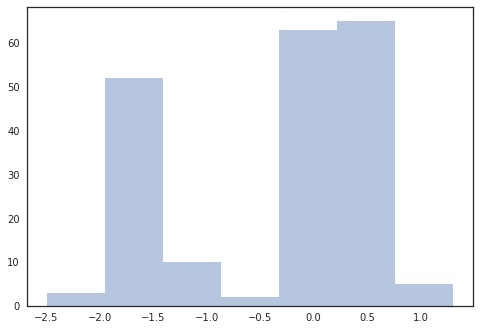

In [61]:
sns.distplot(pred_z, kde=False)

(-40, 40)

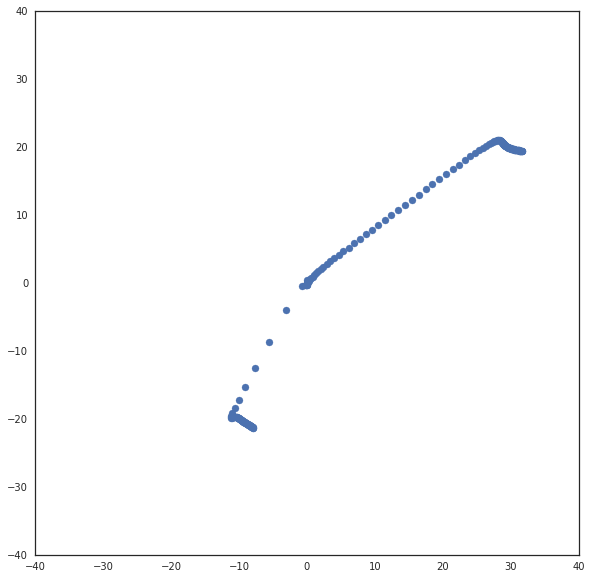

In [62]:
# scan across z and generate
x_gen = sess.run(p_theta, feed_dict={z_phi: np.transpose(np.array([np.linspace(np.min(pred_z), np.max(pred_z), 200)]))})

fig = plt.figure(figsize=(10,10)) # default is (8,6)
ax = fig.add_subplot(111, aspect='equal')
ax.scatter(x_gen[:,0], x_gen[:,1])
ax.set_xlim((-40,40))
ax.set_ylim((-40,40))

In [54]:
phi_vars
sess.run(phi_vars, feed_dict={x: ex})

[array([[ 1.762, -0.713, -1.746,  0.797, -1.043,  1.474,  0.042, -1.186,
          1.017,  0.466,  2.067, -0.799, -1.923,  2.449,  3.7  ,  1.879,
         -0.247, -0.361, -1.737, -2.21 ,  0.364,  0.58 , -2.975,  0.653,
          0.79 , -0.356, -0.053,  2.612,  0.035,  1.61 , -0.412, -0.256,
          1.762,  0.404, -1.572,  1.283, -0.185, -0.647, -1.244,  1.91 ,
         -0.78 , -0.754, -0.66 ,  1.562, -0.998, -1.371, -0.657, -1.629,
         -0.158, -0.641, -0.832, -2.123, -0.879,  0.115, -1.37 , -2.196,
          0.194, -1.381, -0.66 ,  0.382, -0.05 ,  0.48 , -1.037, -1.359,
         -0.449, -0.395,  1.604, -1.57 ,  2.497, -0.085,  0.87 ,  2.279,
         -0.92 , -0.567,  0.006,  0.124,  1.847,  1.476,  0.615, -0.251,
         -0.915, -0.062, -0.968, -2.79 ,  1.606,  0.279, -0.485, -1.256,
         -0.236, -0.015,  1.992, -0.01 , -0.73 ,  2.434, -1.048, -3.431,
         -0.881, -0.887, -0.418,  0.679,  1.22 , -2.125, -0.373,  0.737,
          0.545,  0.384, -0.028,  0.405,  0.597,  0